In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Introduction to Generative Adversarial Networks (GANs)

In this notebook you will build a GAN from scratch, grossly following the DCGAN architecture.

**Goals:**


1.   Build a GAN arhictecture from scratch
2.   Write the GAN loss function and train GAN from scratch
3.   Have experience with some of the instability problems inherent with training GANs.
4.   [Bonus] Extend the unconditional GAN into a conditional GAN.



## 1. Getting Started

We will work with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. It contains 60,000 images size 28x28 of handwritten digits, from 0 to 9.

## 1. Dataloading

### 1.1 Define some hyperparameters and transforms


In [2]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

In [3]:
dataloader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True)

In [4]:
# plot some images
real_batch, real_labels = next(iter(dataloader))

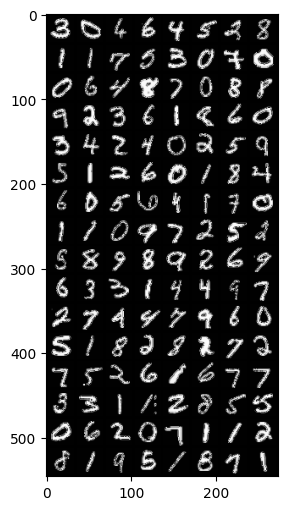

In [5]:
plt.imshow(transforms.ToPILImage()(make_grid(real_batch)))

## 2. Model Architecture

We will follow the general architecture of a DCGAN - or deep convolutional GAN. This [influential paper](https://arxiv.org/pdf/1511.06434v2.pdf) produced much of the foundation for modern GANs and how to train them.

(GANs are notoriously **hard** to train, we will try to get a feeling why in this notebook.)


Complete the function `get_upscaling_block`. Then, use the function to define our model defined as follows:

Input: Random "noise" $z$ shaped `[n_batch, n_z]`

Output: Generated image size `[n_batch, 1, 32, 32]` in range [-1, 1]

1. Reshape z into `[n_batch, n_z, 1, 1]` to make it into an "image"
2. First upscaling block $\rightarrow$ `[n_batch, ngf*4, 4, 4]`
3. Second upscaling block $\rightarrow$ `[n_batch, ngf*2, 8, 8]`
4. Third upscaling block $\rightarrow$ `[n_batch, ngf, 16, 16]`
5. Fourth (and last) upscaling block $\rightarrow$ `[n_batch, 1, 32, 32]`

## 2.1. The Generator



The generator performs subsequent upsampling blocks, transforming a latent vector shaped [batch_size, latent_size] into an image (values in [-1, 1]).

The generator block will consists of:
- Transpose Convolution
- Batch Norm
- ReLU

In [6]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU,
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
        return nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding), nn.Tanh()
    else:
        return nn.ConvTranspose2d(channels_in, channels_out, kernel, stride, padding), nn.BatchNorm2d(channels_out), nn.ReLU()

class Generator(nn.Module):
    def __init__(self, nz, ngf, nchannels=1):
        '''
        nz: The latent size (100 in our case)
        ngf: The channel-size before the last layer (32 our case)
        '''
        super().__init__()
        self.model = nn.Sequential(
            *get_upscaling_block(nz, ngf * 4, (4, 4), 1, 0), 
            *get_upscaling_block(ngf * 4, ngf * 2, (4, 4), 2, 1),
            *get_upscaling_block(ngf * 2, ngf, (4, 4), 2, 1),
            *get_upscaling_block(ngf, nchannels, (4, 4), 2, 1, True)            
        )


    def forward(self, z):
        x = z.unsqueeze(2).unsqueeze(2) # give spatial dimensions to z
        return self.model(x)


### 2.1.3. Sanity Tests

In [7]:
nz = 1000
z = torch.randn(batch_size, nz)

In [8]:
G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

G = Generator(nz=nz, ngf=16)
assert G(z).shape == (batch_size, 1, 32, 32)

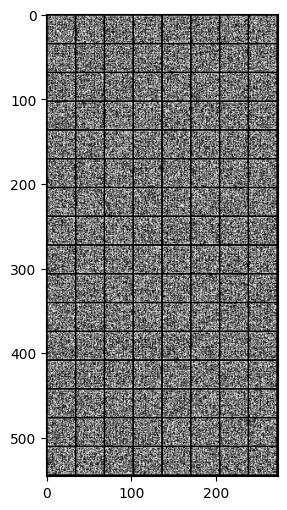

In [9]:
# visualize the output - at first it should just look like random noise!!
x_fake = G(z)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

## 2.2. The discriminator

The discriminator will be a mirror image of the generator.

The discriminator will also use a fully convolutional architecutre, with each block consisting of:
- Conv layer
- BatchNorm
- ReLU

Complete the function `get_downscaling_block` and then use it to define the following architecture for the discriminator:

Input: Image shaped `[n_batch, 1, 32, 32]` (in [-1, 1])
Output: Discriminator scores `[n_batch, 1]` in range [0, 1]

1. First downscaling block $\rightarrow$ `[n_batch, ndf, 16, 16]`
2. Second downscaling block $\rightarrow$ `[n_batch, ndf*2, 8, 8]`
3. Third downscaling block $\rightarrow$ `[n_batch, ndf*4, 4, 4]`
4. Last downscaling block $\rightarrow$ `[n_batch, 1]`

In [10]:
def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):

    if is_last:
        return nn.Conv2d(channels_in, channels_out, kernel, stride, padding), nn.Sigmoid()

    elif not use_batch_norm:
        return nn.Conv2d(channels_in, channels_out, kernel, stride, padding), nn.LeakyReLU(0.2)

    else:
        return nn.Conv2d(channels_in, channels_out, kernel, stride, padding), nn.BatchNorm2d(channels_out), nn.LeakyReLU(0.2)




class Discriminator(nn.Module):
    def __init__(self, ndf, nchannels=1):
        super().__init__()

        self.model = nn.Sequential(
            *get_downscaling_block(nchannels, ndf, 4, 2, 1, use_batch_norm=False),
            *get_downscaling_block(ndf, ndf*2, 4, 2, 1),
            *get_downscaling_block(ndf*2, ndf*4, 4, 2, 1),
            *get_downscaling_block(ndf*4, 1, 4, 1, 0, use_batch_norm=False, is_last=True)
        )


    def forward(self, x):
        return self.model(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 2.2.3 Sanity Checking

In [11]:
real_batch, real_labels = next(iter(dataloader))

In [12]:
D = Discriminator(ndf=32, nchannels=1)
assert D(real_batch).shape == (real_batch.shape[0], 1)

# 3. Training

## 3.1 Loss
The essential thing to remember is that the logistic and the non-saturating logistic GAN losses can be written exclusively using the [binary cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Our GAN loss will be defined ONLY using the following criterion:



In [13]:
criterion = nn.BCELoss() # we will build off of this to make our final GAN loss!

## 3.2 Helper functions

We will need a few helper functions.
1. First, we need to continuously sample z from a Gaussian distribution.
2. Secondly, we need to make our "ground-truth" labels when using the BCE loss. This should output vectors of either 0s or 1s.

In [14]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1)
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

## 3.3 Creating the optimizers and hyperparameters

The original DCGAN paper shows that Adam works well in the generator and the discriminator with a learning rate of 0.0002 and Beta1 = 0.5.

Define your optimizers

In [15]:
nz = 100
ngf = 32
ndf = 32

nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

netD = Discriminator(ndf, nchannels).to(device)
netG = Generator(nz, ngf).to(device)

netD.apply(weights_init)
netG.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))


## 3.3 Training!

Now for the fun part, training!
Training a GAN consists in making an update to the discriminator, then the generator.
Training a GAN requires BABYSITTING!! Remember that many things can go wrong when training a GAN:
- The discriminator is too strong for the generator - the generator cannot improve.
- The generator easily fools the discriminator - cannot learn.
- Mode collapse - generator is not capable of generating diverse images.

it: 0; g_loss: 1.549457311630249; d_loss: 0.7401789426803589; avg_real_score: 0.5774635076522827; avg_fake_score: 0.588008463382721: : 0it [00:01, ?it/s]

generated images


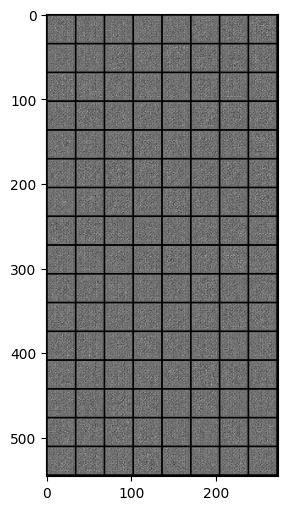

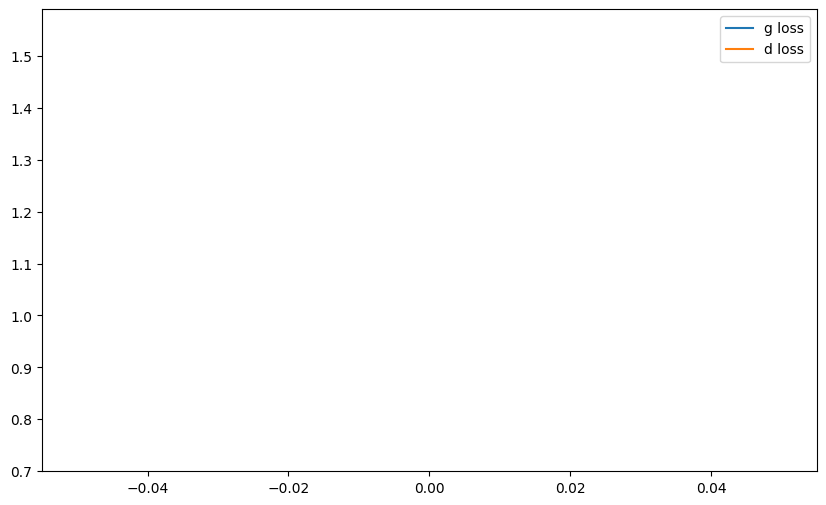

it: 200; g_loss: 1.2547483444213867; d_loss: 0.5365392565727234; avg_real_score: 0.5869214534759521; avg_fake_score: 0.37358617782592773: : 199it [00:24, 10.31it/s] 

generated images


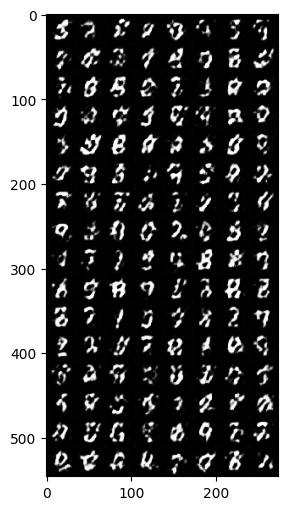

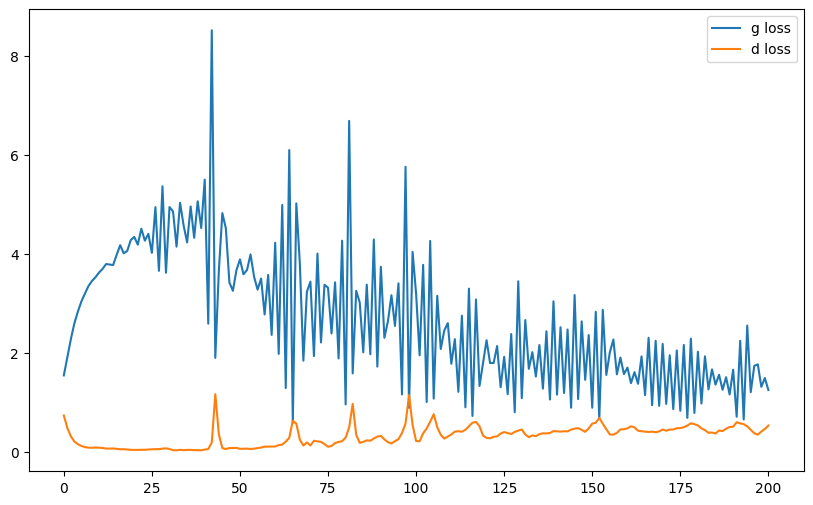

it: 400; g_loss: 2.212550640106201; d_loss: 0.5765514373779297; avg_real_score: 0.8036305904388428; avg_fake_score: 0.5872795581817627: : 400it [00:46,  8.09it/s]   

generated images


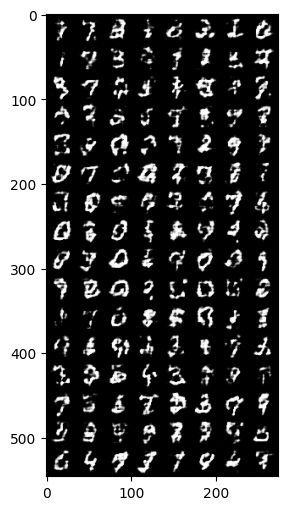

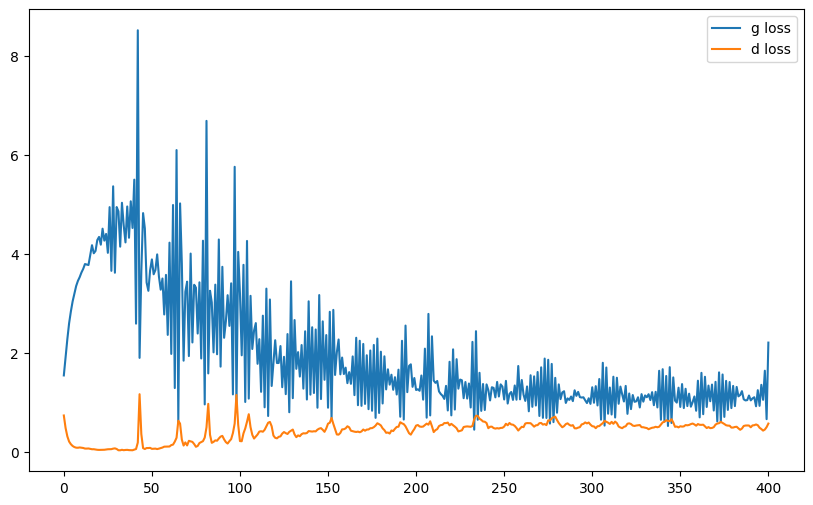

it: 468; g_loss: 1.0150587558746338; d_loss: 0.5047820210456848; avg_real_score: 0.5716880559921265; avg_fake_score: 0.3391314148902893: : 469it [00:55,  8.50it/s]  
it: 469; g_loss: 1.3316478729248047; d_loss: 0.5284419059753418; avg_real_score: 0.6619598269462585; avg_fake_score: 0.455082505941391: : 0it [00:00, ?it/s]

generated images


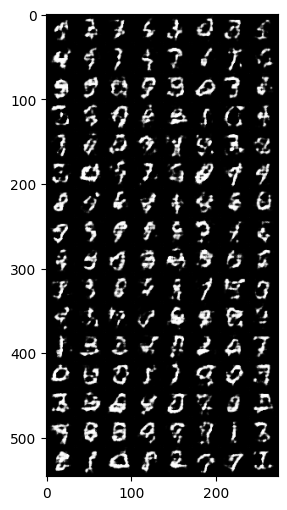

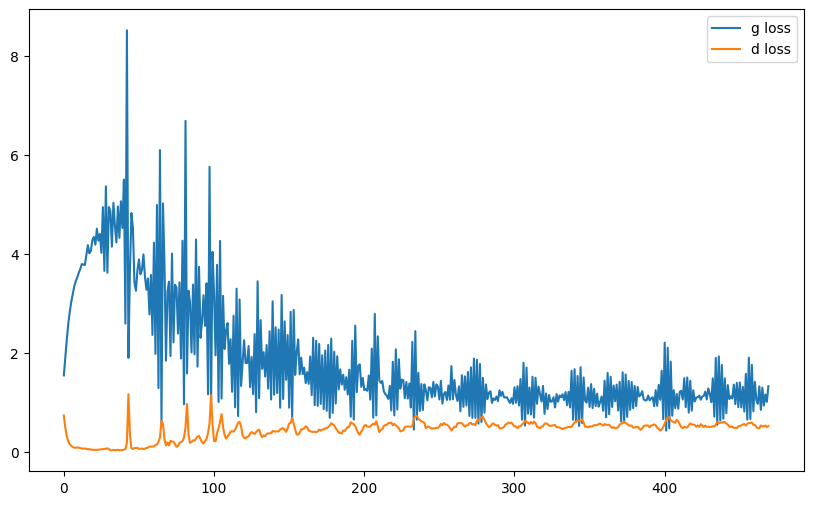

it: 669; g_loss: 0.844356119632721; d_loss: 0.5678478479385376; avg_real_score: 0.5019317269325256; avg_fake_score: 0.33797553181648254: : 199it [00:23,  7.77it/s]  

generated images


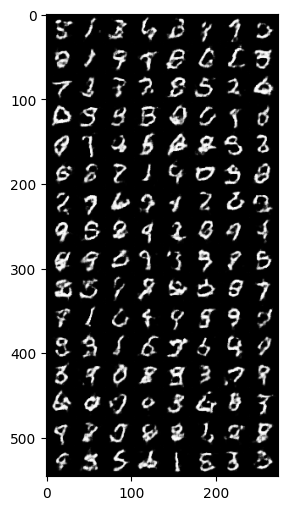

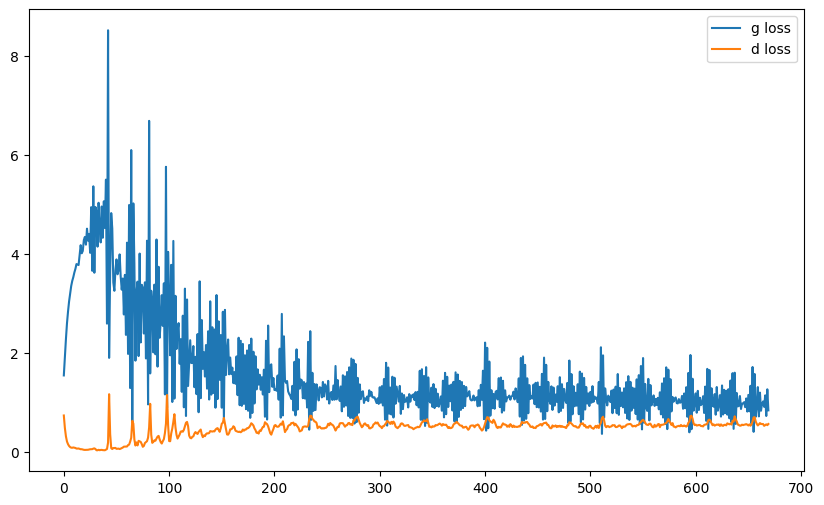

it: 869; g_loss: 1.0216639041900635; d_loss: 0.5241278409957886; avg_real_score: 0.5952374935150146; avg_fake_score: 0.38734883069992065: : 399it [00:46,  8.58it/s]  

generated images


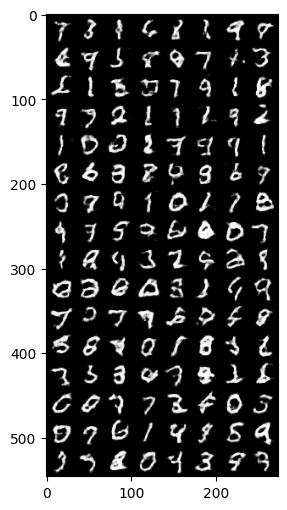

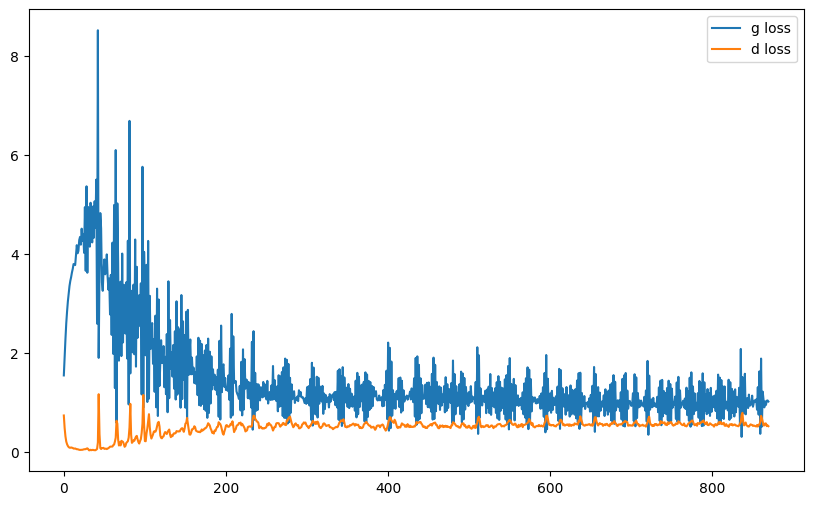

it: 937; g_loss: 2.0764336585998535; d_loss: 0.6815047860145569; avg_real_score: 0.8461617231369019; avg_fake_score: 0.6840337514877319: : 469it [00:53,  8.84it/s]  
it: 938; g_loss: 0.55487060546875; d_loss: 0.6822509169578552; avg_real_score: 0.33881592750549316; avg_fake_score: 0.1905037760734558: : 0it [00:00, ?it/s]

generated images


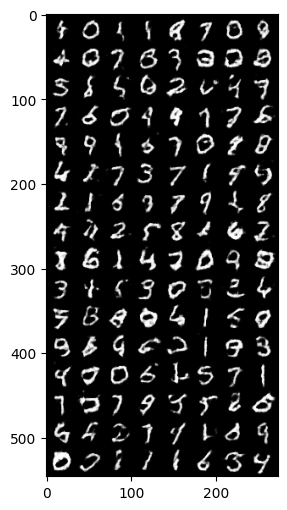

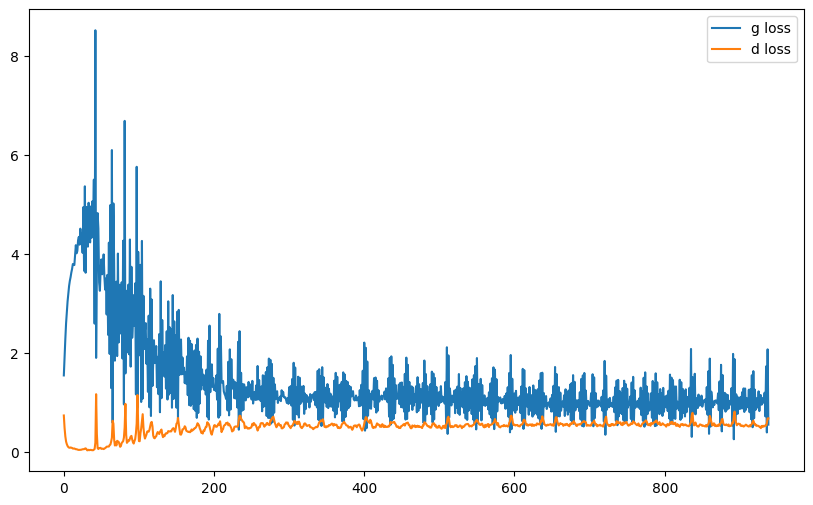

it: 1138; g_loss: 0.9399071335792542; d_loss: 0.5178250074386597; avg_real_score: 0.5465960502624512; avg_fake_score: 0.33243894577026367: : 199it [00:16, 12.83it/s]  

generated images


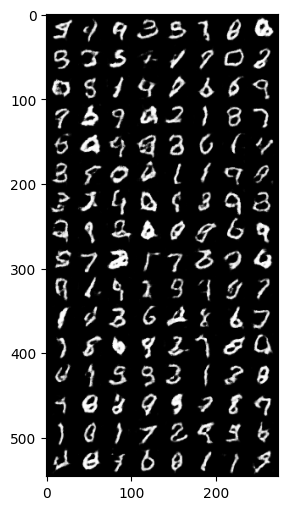

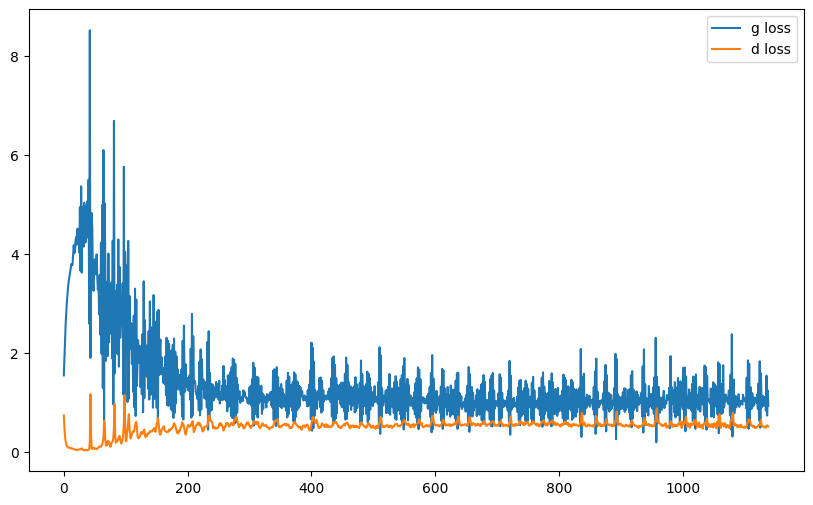

it: 1338; g_loss: 0.9576583504676819; d_loss: 0.504183292388916; avg_real_score: 0.6073955297470093; avg_fake_score: 0.3849671185016632: : 399it [00:32, 12.12it/s]   

generated images


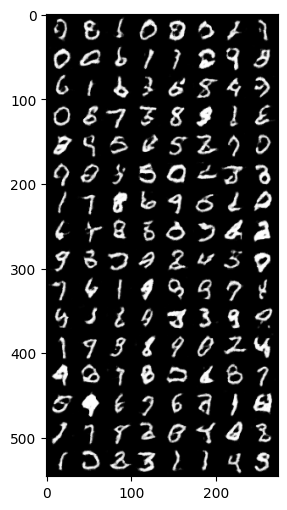

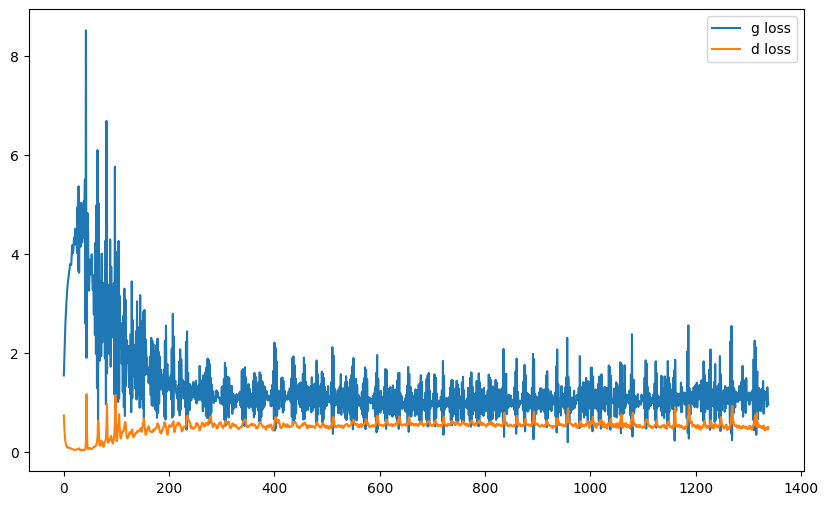

it: 1406; g_loss: 2.454073190689087; d_loss: 0.6428876519203186; avg_real_score: 0.8720582723617554; avg_fake_score: 0.667061448097229: : 469it [00:37, 12.47it/s]    
it: 1407; g_loss: 0.419384241104126; d_loss: 0.738510012626648; avg_real_score: 0.2748016119003296; avg_fake_score: 0.11619973182678223: : 0it [00:00, ?it/s]

generated images


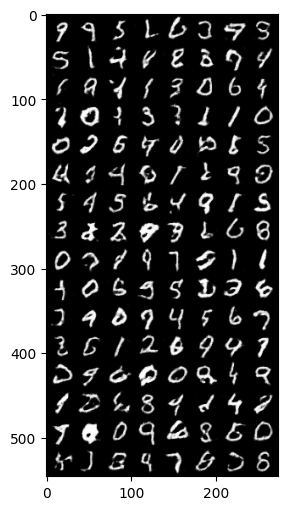

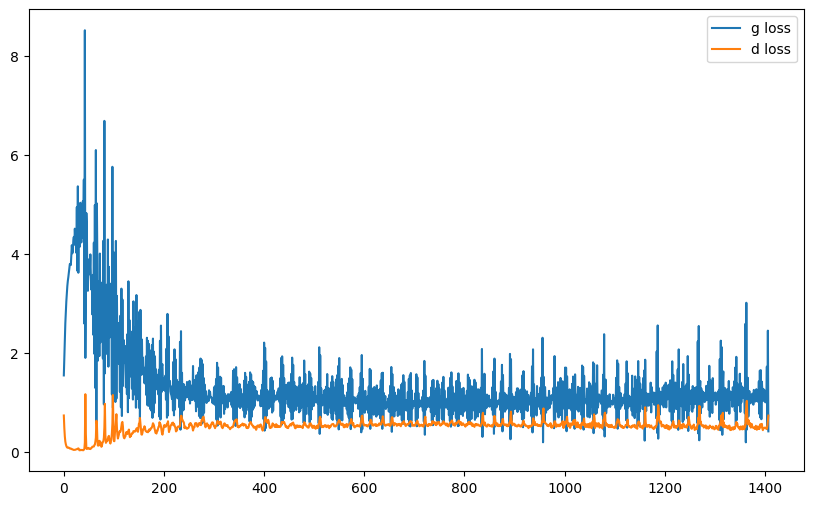

it: 1607; g_loss: 0.7868132591247559; d_loss: 0.4808555245399475; avg_real_score: 0.5086309313774109; avg_fake_score: 0.2225772887468338: : 200it [00:16, 12.39it/s]  

generated images


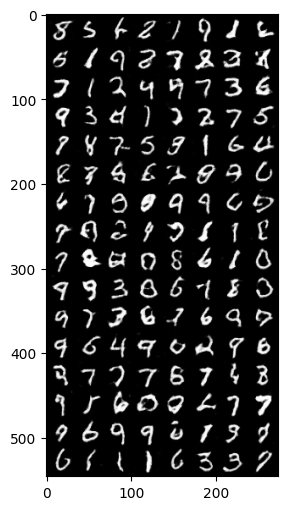

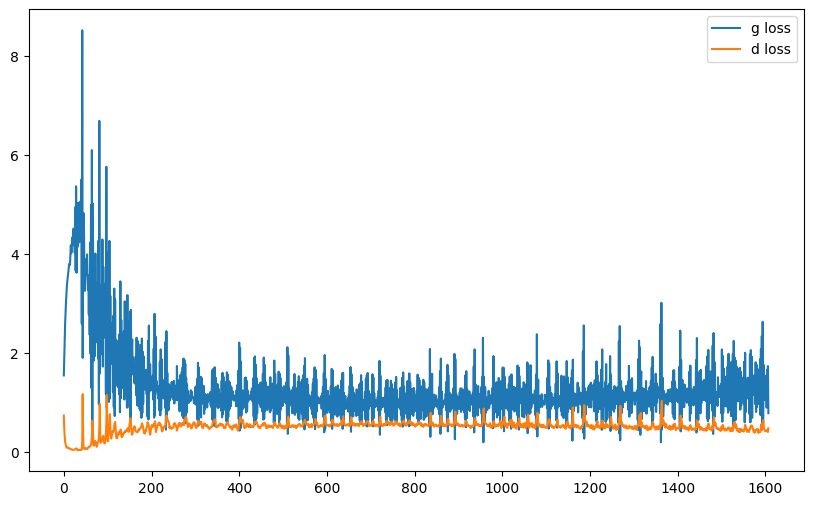

it: 1807; g_loss: 1.7843964099884033; d_loss: 0.30905574560165405; avg_real_score: 0.7991688847541809; avg_fake_score: 0.31455206871032715: : 400it [00:32, 12.30it/s] 

generated images


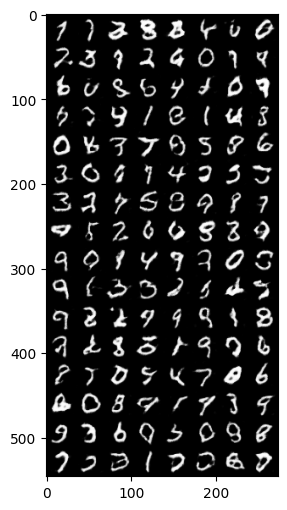

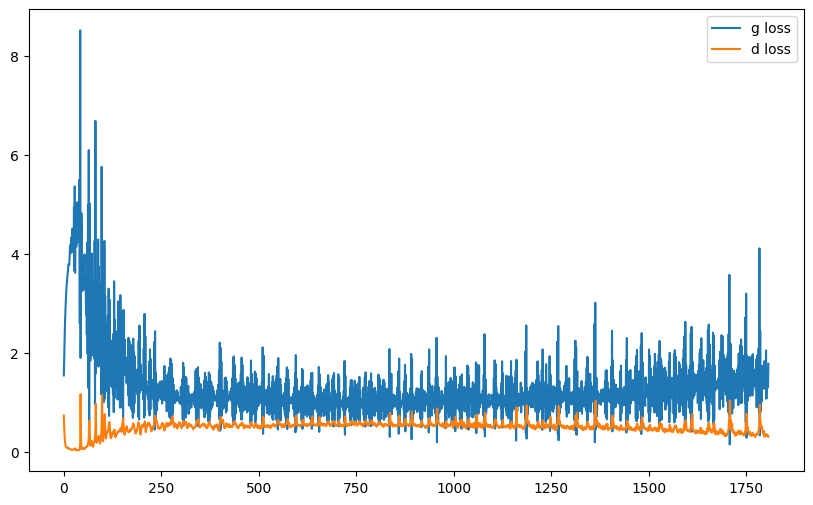

it: 1875; g_loss: 1.7818422317504883; d_loss: 0.26828300952911377; avg_real_score: 0.7304608225822449; avg_fake_score: 0.18862971663475037: : 469it [00:37, 12.52it/s]
it: 1876; g_loss: 1.8927466869354248; d_loss: 0.2951383590698242; avg_real_score: 0.8039535284042358; avg_fake_score: 0.29825156927108765: : 0it [00:00, ?it/s]

generated images


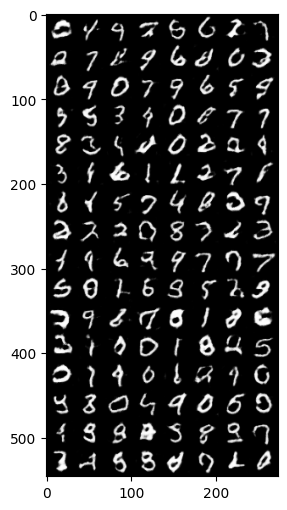

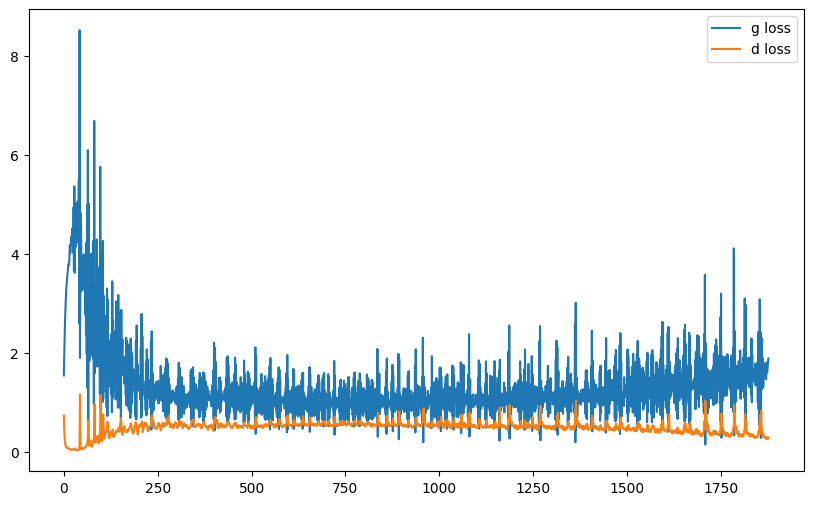

it: 2076; g_loss: 2.770826816558838; d_loss: 0.30382129549980164; avg_real_score: 0.8702570796012878; avg_fake_score: 0.36062830686569214: : 200it [00:15, 13.11it/s]   

generated images


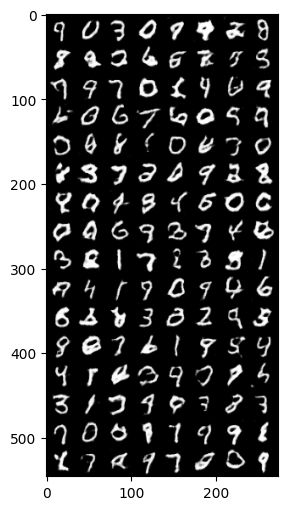

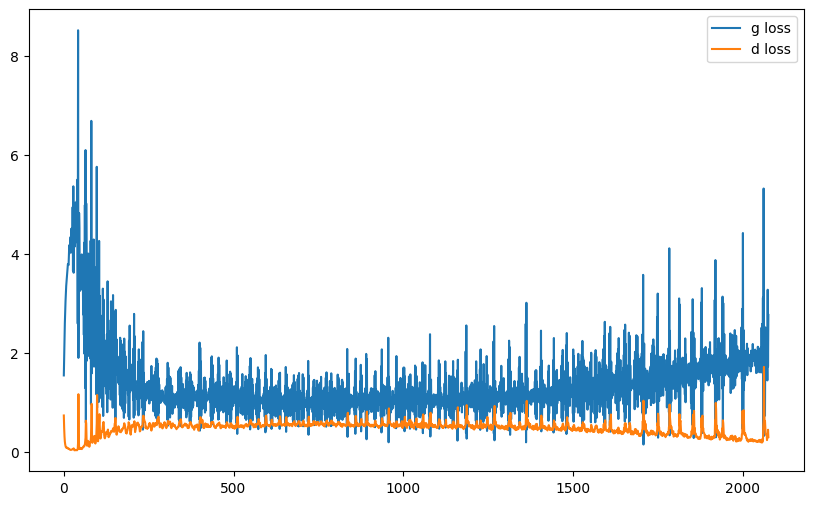

it: 2276; g_loss: 2.0364556312561035; d_loss: 0.20135845243930817; avg_real_score: 0.8373470306396484; avg_fake_score: 0.19286644458770752: : 400it [00:30, 15.76it/s] 

generated images


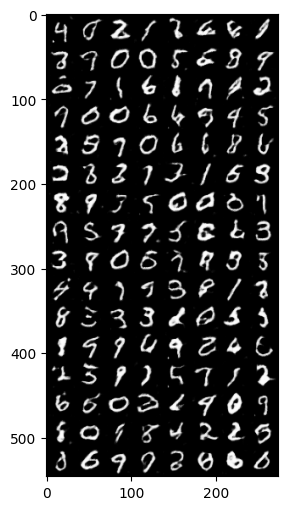

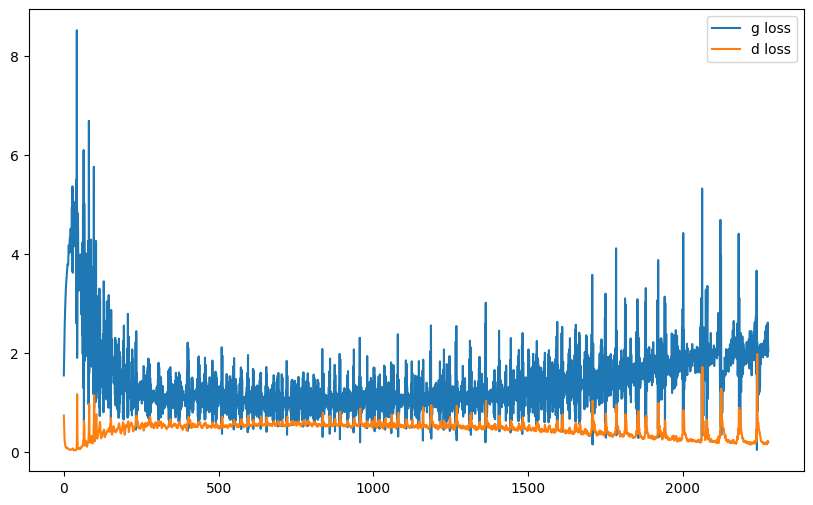

it: 2344; g_loss: 2.326335906982422; d_loss: 0.14593631029129028; avg_real_score: 0.8453152179718018; avg_fake_score: 0.10850898921489716: : 469it [00:36, 12.94it/s]  


In [16]:
nb_epochs = 5

g_losses = []
d_losses = []
torch.autograd.set_detect_anomaly(True)


j = 0


z_test = sample_z(64, nz) # we generate the noise only once for testing

for epoch in range(nb_epochs):

    # train
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, _ = batch # we don't care about the label for unconditional generation
        im = im.to(device)

        cur_batch_size = im.shape[0]
        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z)

        # 3. Classify real image with D
        yhat_real = netD(im)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im)
        
        real_loss = criterion(yhat_real, get_labels_one(cur_batch_size))
        fake_loss = criterion(yhat_fake, get_labels_zero(cur_batch_size))
    
        ###
        ### Discriminator
        ###

        d_loss = (real_loss + fake_loss) / 2
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        ###
        ### Generator
        ###

        g_loss = criterion(netD(fake_im), get_labels_one(cur_batch_size))#      YOUR CODE HERE
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()



        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        if i % display_freq == 0:

            #fake_im = G(z_test)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=8)
            pil_grid = to_pil(grid)

            print("generated images")
            plt.imshow(pil_grid)
            plt.show()

            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1

# 4. Conditional GANs [BONUS]

A simple way to improve training performance and obtain control of the generation is to provide extra information into the Generator and the Discriminator, known as **Conditional GANs**. In this case, we will provide the class label (digit number of MNIST) into both the generator and the discriminator. This will help both of the networks.

## 4.1 Conditional Generator and Discriminator

Complete the ConditionalDiscriminator and ConditionalGenerator classes using your GAN building blocks (`get_upsampling_block` and `get_downsampling_block` functions).


### 4.1.1 Generator

In [57]:
# GENERATOR

'''
The conditional generator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the generator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()

        self.upscaling_z = nn.Sequential(*get_upscaling_block(nz, ngf*8, 4, 1, 0))
        self.upscaling_c = nn.Sequential(*get_upscaling_block(nc, ngf*8, 4, 1, 0))

        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        self.rest_model = nn.Sequential(
            *get_upscaling_block(ngf * 16, ngf * 8, 4, 2, 1),
            *get_upscaling_block(ngf * 8, ngf * 4, 4, 2, 1),
            *get_upscaling_block(ngf * 4, 1, 4, 2, 1, last_layer=True),
        )

        ###################

    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)

        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        x = self.upscaling_z(x)
        y = self.upscaling_c(y)
        
        x = torch.cat([x, y], dim=1)

        return self.rest_model(x)

### 4.1.2 Discriminator

In [58]:
# Discriminator

'''
The conditional discriminator needs the label information as well as the latent vector. We will combine the latent vector and the class information in the following way:

- The class information for the discriminator will be represented as a one-hot vector sized `[batch_size, 10]` (since there are 10 classes in MNIST)
- The latent vector for the generator will still be sized `[batch_size, nz]`

1. Transform both of these modalities into 'images' (by adding dimensions)
2. Like before, apply the first upscaling block to both of these 'images'. We will now have 2 separate blocks sized

'''

class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = nn.Sequential(*get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=False))
        self.downscale_y = nn.Sequential(*get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=False))
        self.y_projection = nn.Linear(10, 32 * 32 * 10)

        ###################
        #                 #
        # YOUR CODE HERE  #

        self.rest = nn.Sequential(
            *get_downscaling_block(ndf * 4, ndf * 8, 4, 2, 1, use_batch_norm=True),
            *get_downscaling_block(ndf * 8, ndf * 16, 4, 2, 1, use_batch_norm=True),
            *get_downscaling_block(ndf * 16, 1, 4, 1, 0, use_batch_norm=False, is_last=True),
        )

        #                 #
        ###################

    def forward(self, x, y):
        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        x = self.downscale_x(x)
        y = self.downscale_y(self.y_projection(y).reshape(y.shape[0], 10, 32, 32))
        
        x = torch.cat([x, y], dim=1)

        return self.rest(x).squeeze(1).squeeze(1) # remove spatial dimensions

### 4.1.3 Sanity Checks

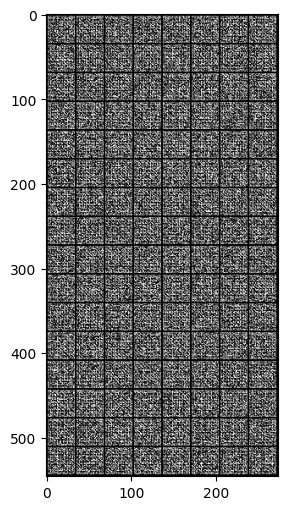

In [59]:
# CONDITIONAL GENERATOR SANITY CHECKING

z = torch.randn(batch_size, nz)
y = F.one_hot(real_labels).float()

cG = ConditionalGenerator(nz=nz, ngf=16, nc=10)
x_fake = cG(z, y)
plt.imshow(transforms.ToPILImage()(make_grid(x_fake, nrow=8)))

In [60]:
# Conditional Discriminator Sanity Checking

cD = ConditionalDiscriminator(ndf=32, nc=10, nchannels=1)
assert cD(real_batch, F.one_hot(real_labels).float()).shape == (real_batch.shape[0], 1)

## 4.2 Training

In [63]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)

netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



it: 0; g_loss: 13.331511497497559; d_loss: 0.919310450553894; avg_real_score: 0.6800096035003662; avg_fake_score: 0.7193660140037537: : 0it [00:00, ?it/s]

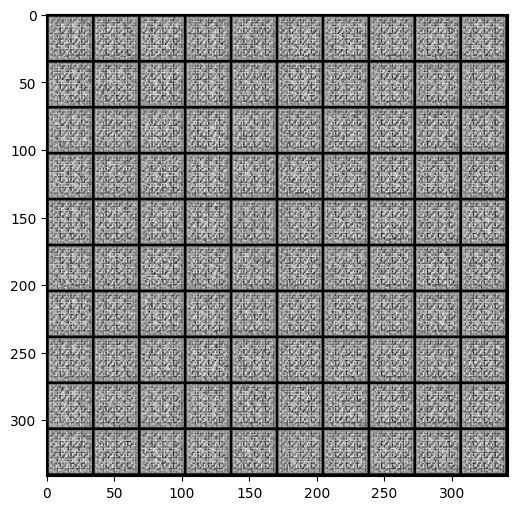

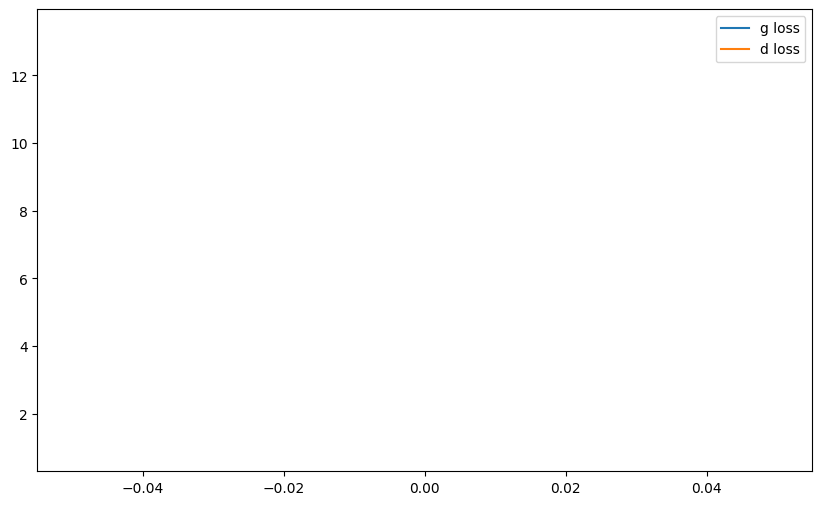

it: 200; g_loss: 1.6583971977233887; d_loss: 0.5685487389564514; avg_real_score: 0.5977204442024231; avg_fake_score: 0.40715402364730835: : 200it [00:26,  8.20it/s]  

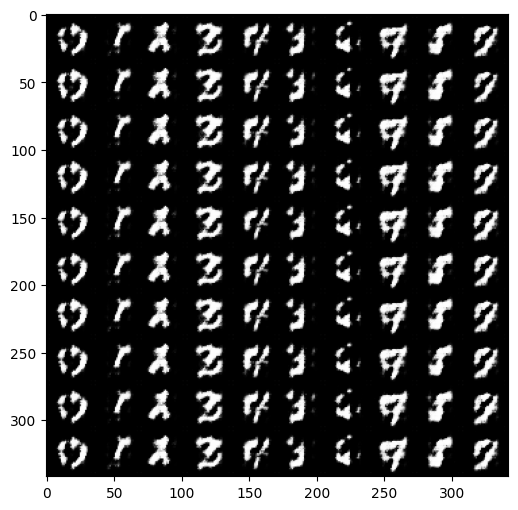

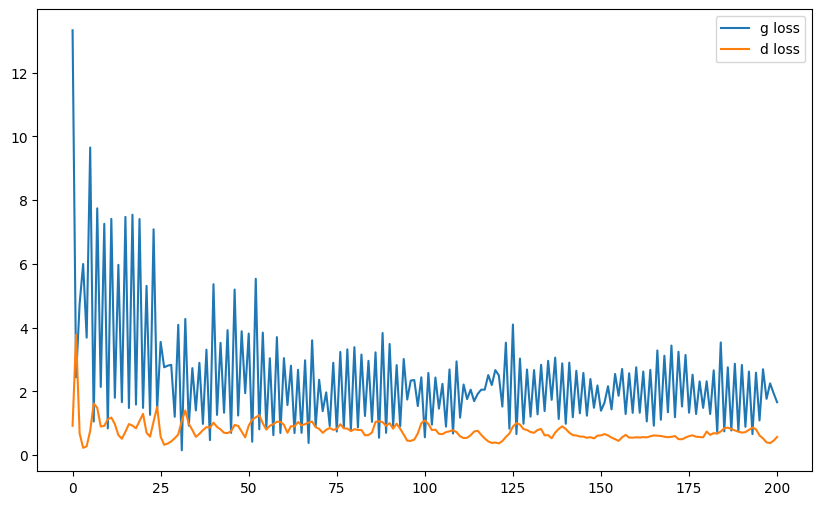

it: 400; g_loss: 2.161405563354492; d_loss: 0.5730209350585938; avg_real_score: 0.6683322191238403; avg_fake_score: 0.45909446477890015: : 400it [00:52,  8.41it/s]   

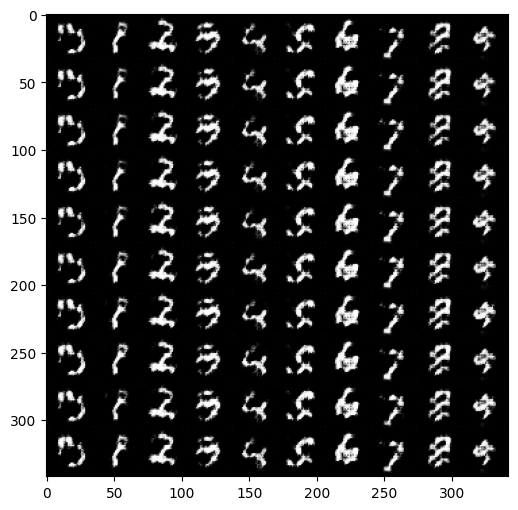

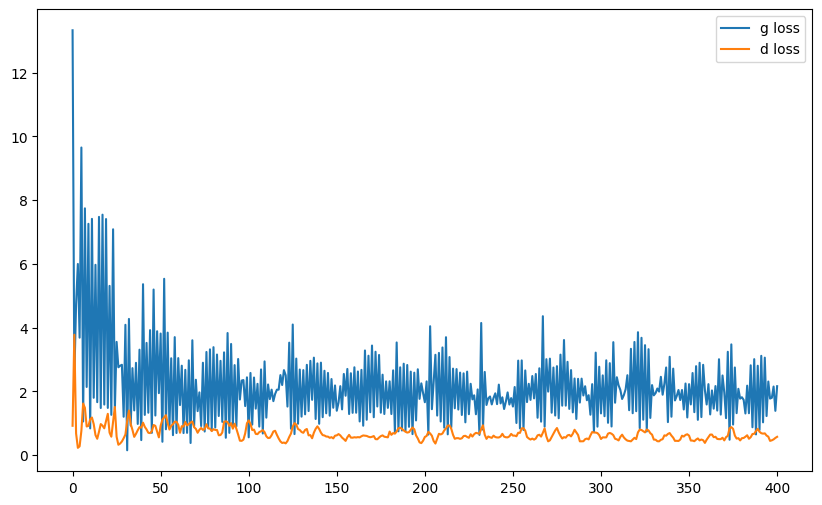

it: 468; g_loss: 2.510427474975586; d_loss: 0.5433362126350403; avg_real_score: 0.670350968837738; avg_fake_score: 0.43497174978256226: : 469it [01:01,  7.65it/s]   
it: 469; g_loss: 1.199507474899292; d_loss: 0.6184463500976562; avg_real_score: 0.4933461844921112; avg_fake_score: 0.27372193336486816: : 0it [00:00, ?it/s]

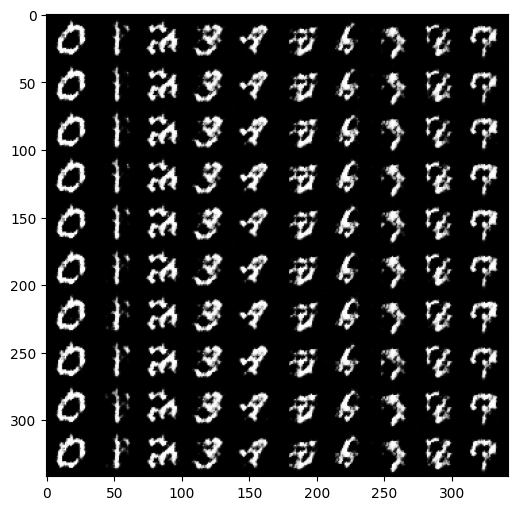

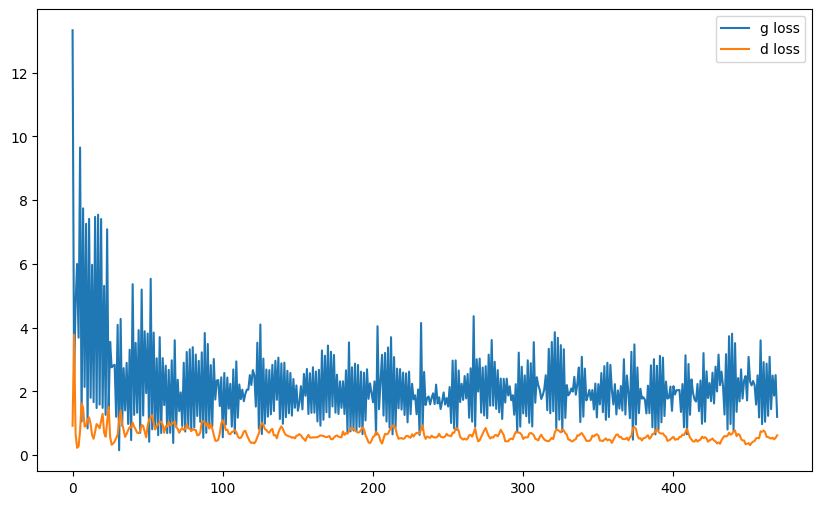

it: 669; g_loss: 0.9934029579162598; d_loss: 0.6190502047538757; avg_real_score: 0.44656580686569214; avg_fake_score: 0.15120583772659302: : 200it [00:24,  8.56it/s]

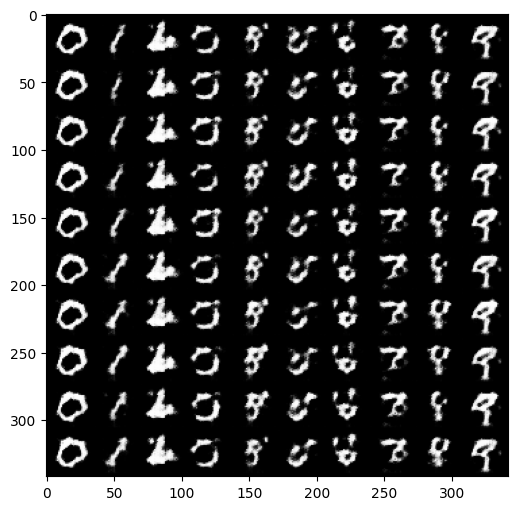

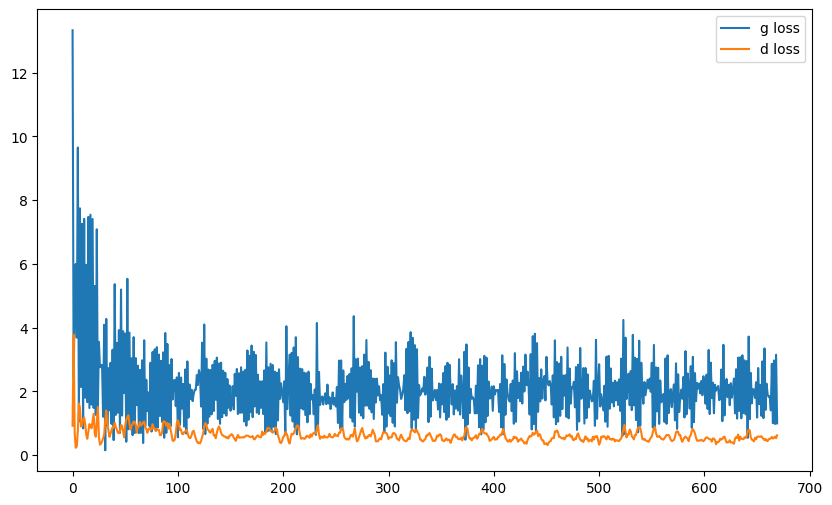

it: 869; g_loss: 2.939774513244629; d_loss: 0.5785775184631348; avg_real_score: 0.7897518277168274; avg_fake_score: 0.5629329681396484: : 400it [00:47,  9.04it/s]   

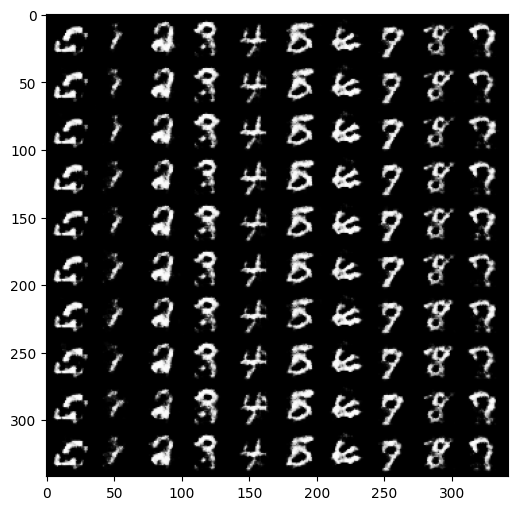

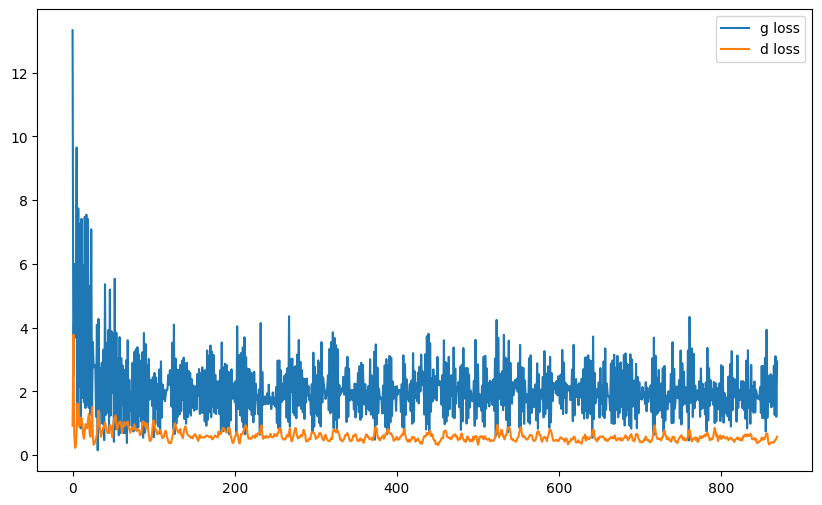

it: 937; g_loss: 2.4372243881225586; d_loss: 0.4219590425491333; avg_real_score: 0.6993247270584106; avg_fake_score: 0.31234288215637207: : 469it [00:55,  8.48it/s] 
it: 938; g_loss: 1.579075813293457; d_loss: 0.5474709272384644; avg_real_score: 0.5914912223815918; avg_fake_score: 0.318933367729187: : 0it [00:00, ?it/s]

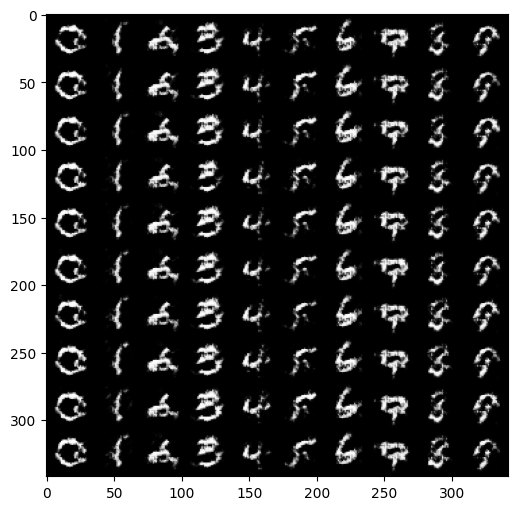

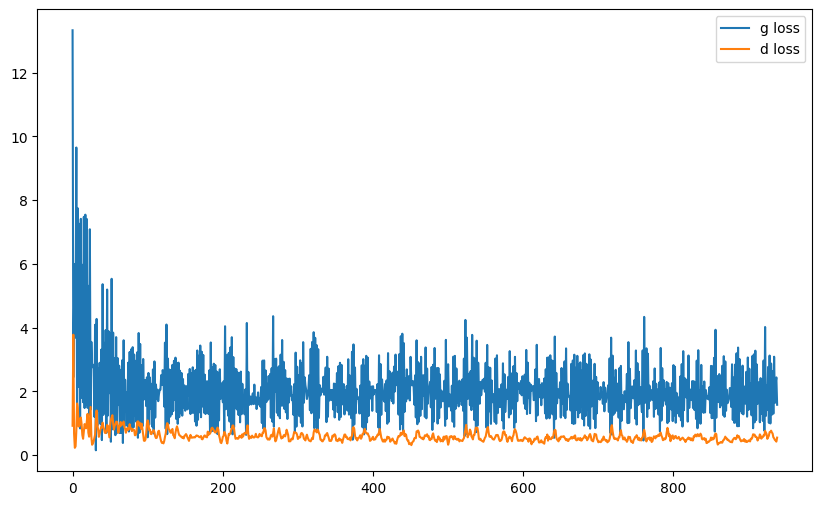

it: 1138; g_loss: 2.8016715049743652; d_loss: 0.6841248273849487; avg_real_score: 0.7414455413818359; avg_fake_score: 0.6211223602294922: : 200it [00:23,  8.21it/s]  

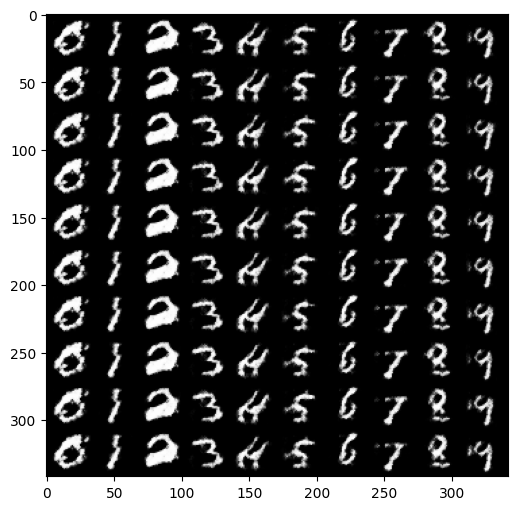

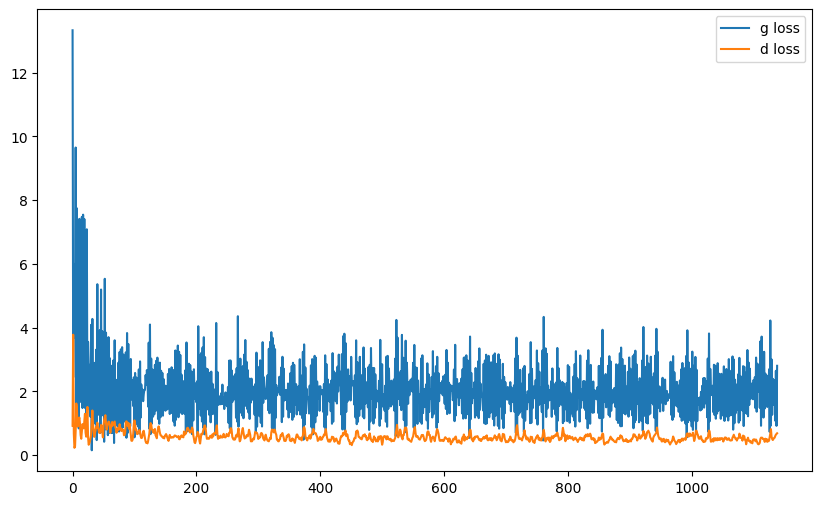

it: 1338; g_loss: 1.0204945802688599; d_loss: 0.8381525874137878; avg_real_score: 0.3200584948062897; avg_fake_score: 0.04474090784788132: : 400it [00:48,  8.55it/s]  

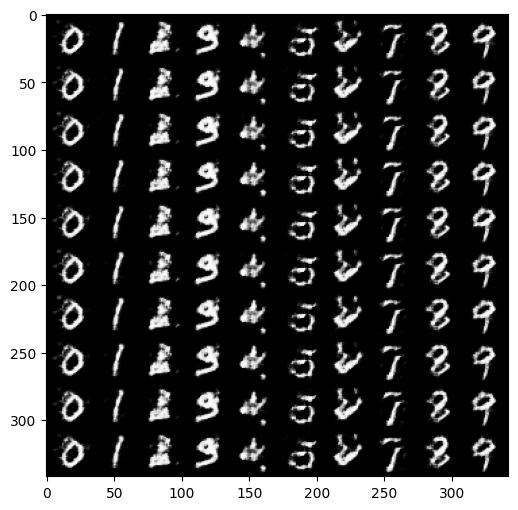

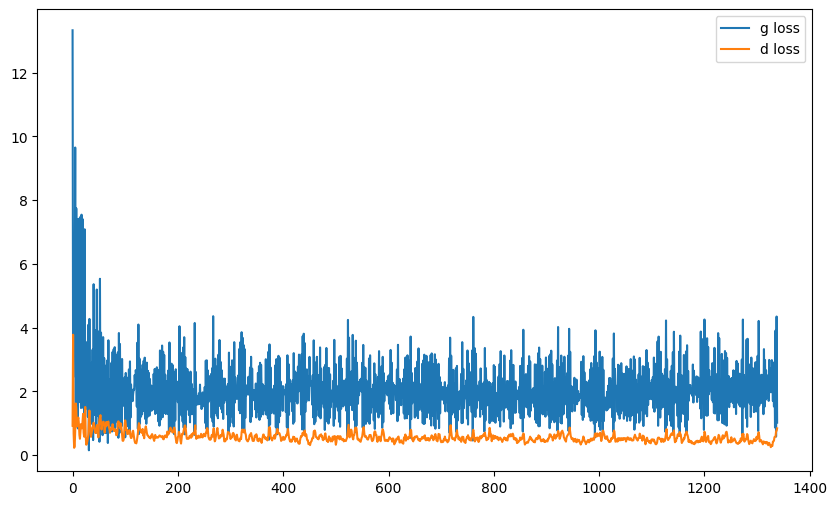

it: 1406; g_loss: 1.0899537801742554; d_loss: 0.48930785059928894; avg_real_score: 0.5519727468490601; avg_fake_score: 0.1747845709323883: : 469it [00:56,  8.29it/s] 
it: 1407; g_loss: 4.304062366485596; d_loss: 0.48433902859687805; avg_real_score: 0.8829473257064819; avg_fake_score: 0.5608283281326294: : 0it [00:00, ?it/s]

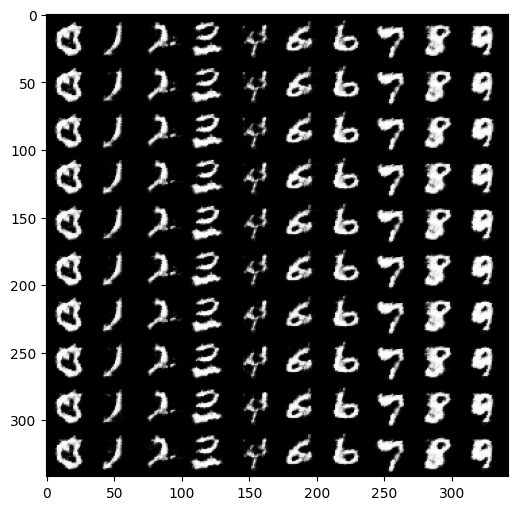

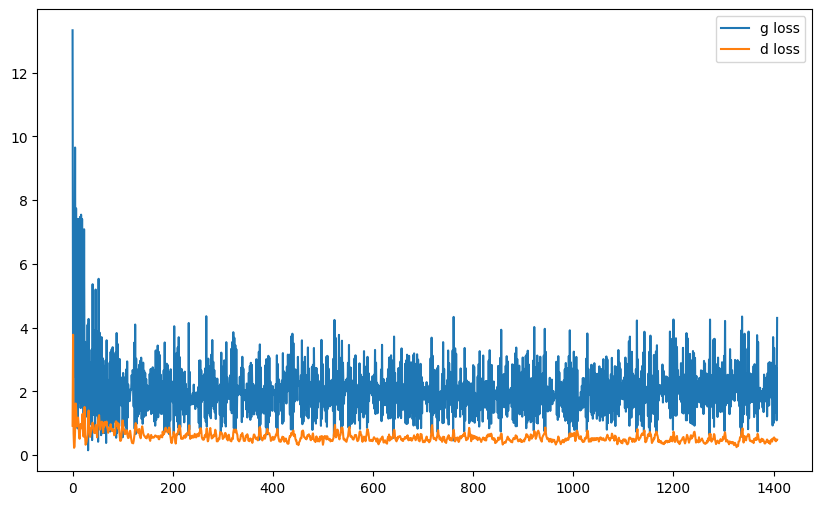

it: 1607; g_loss: 1.4190645217895508; d_loss: 0.44215941429138184; avg_real_score: 0.6029322147369385; avg_fake_score: 0.16946497559547424: : 200it [00:23,  8.59it/s] 

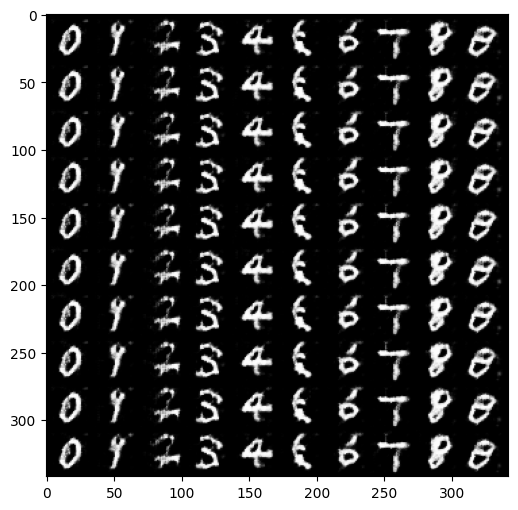

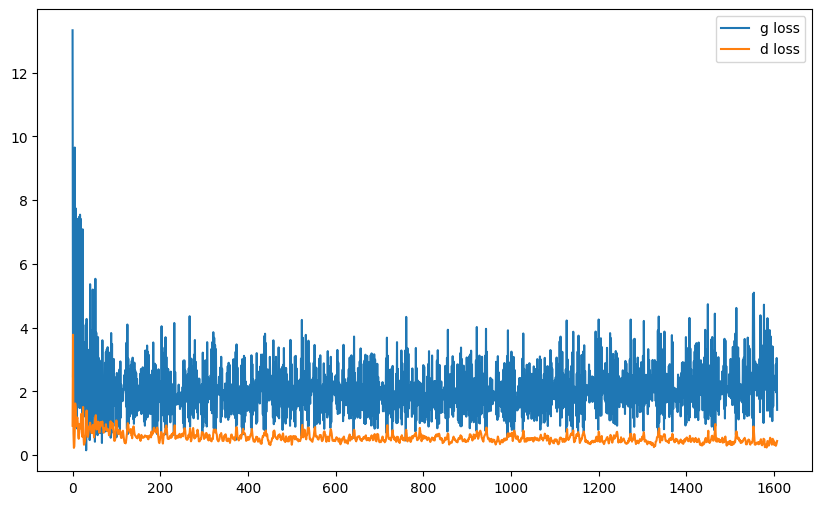

it: 1807; g_loss: 3.0941333770751953; d_loss: 0.5868865847587585; avg_real_score: 0.781962513923645; avg_fake_score: 0.575807511806488: : 400it [00:47,  8.48it/s]     

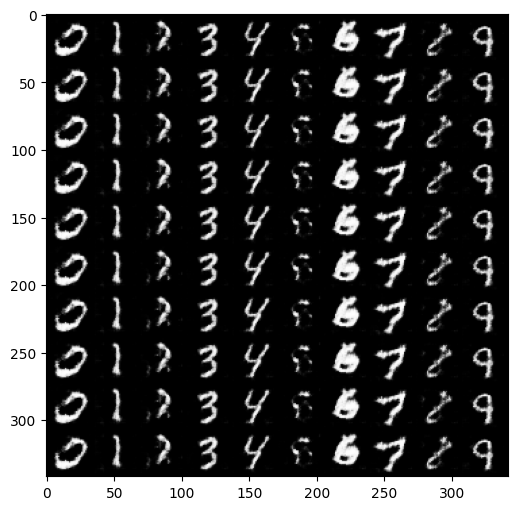

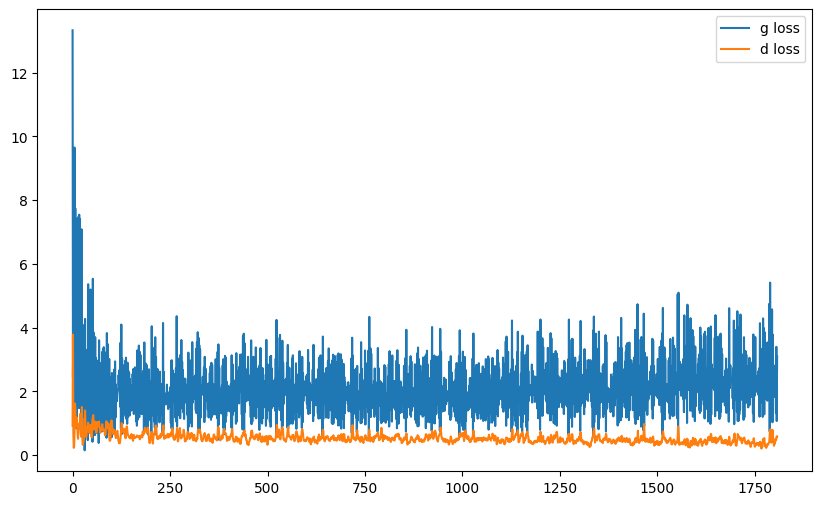

it: 1875; g_loss: 2.786177396774292; d_loss: 0.5755888223648071; avg_real_score: 0.8486558794975281; avg_fake_score: 0.525810182094574: : 469it [00:55,  8.50it/s]     
it: 1876; g_loss: 2.641572952270508; d_loss: 0.378013551235199; avg_real_score: 0.6954851150512695; avg_fake_score: 0.24144183099269867: : 0it [00:00, ?it/s]

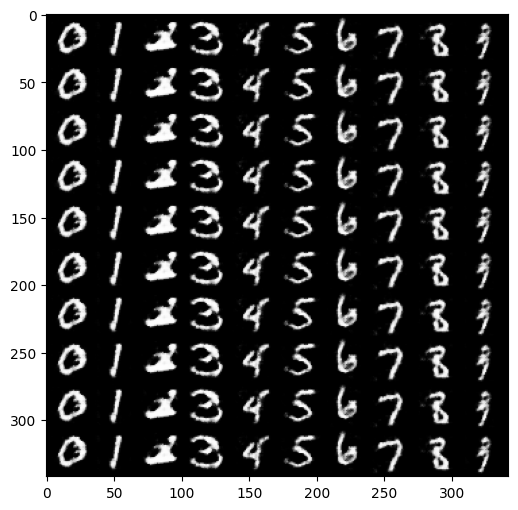

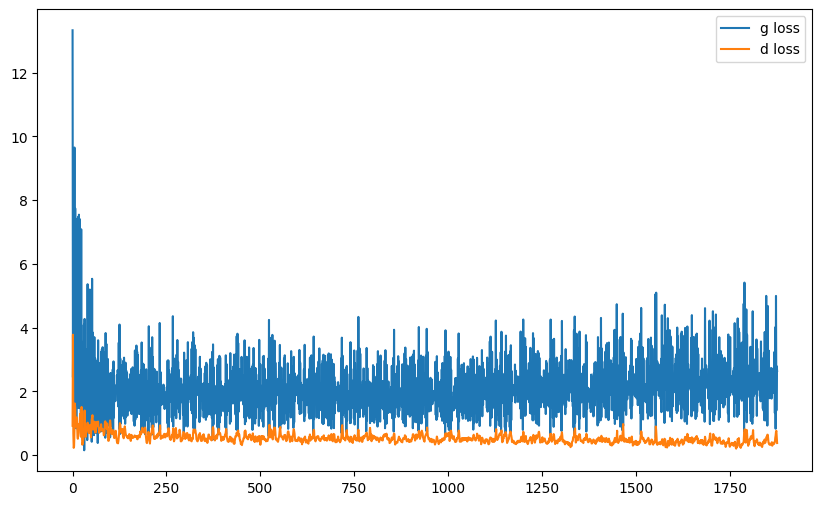

it: 2076; g_loss: 2.1427502632141113; d_loss: 0.27462896704673767; avg_real_score: 0.7261402606964111; avg_fake_score: 0.10922166705131531: : 200it [00:23,  8.32it/s]

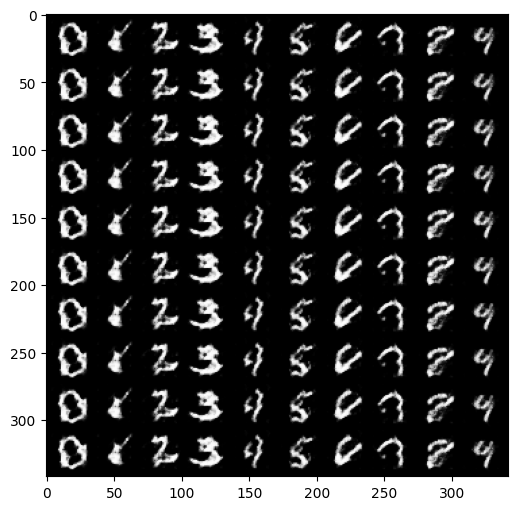

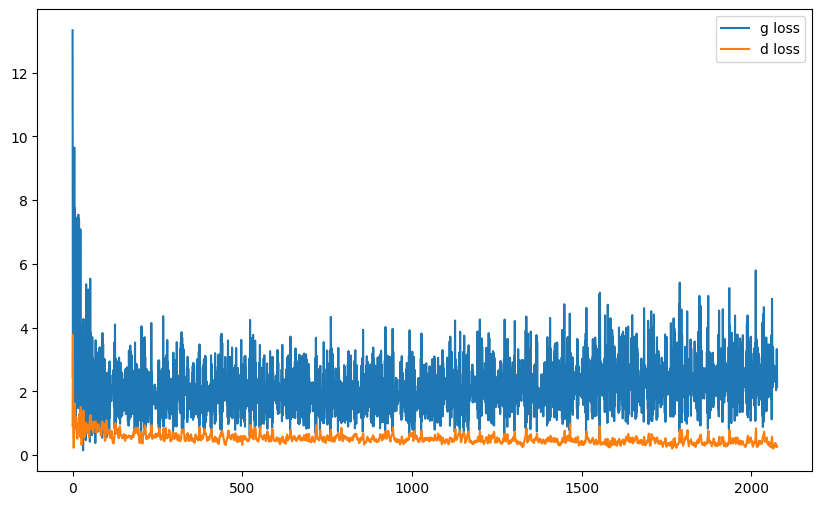

it: 2276; g_loss: 4.415982723236084; d_loss: 0.27940332889556885; avg_real_score: 0.902619481086731; avg_fake_score: 0.3332805037498474: : 400it [00:46,  8.76it/s]    

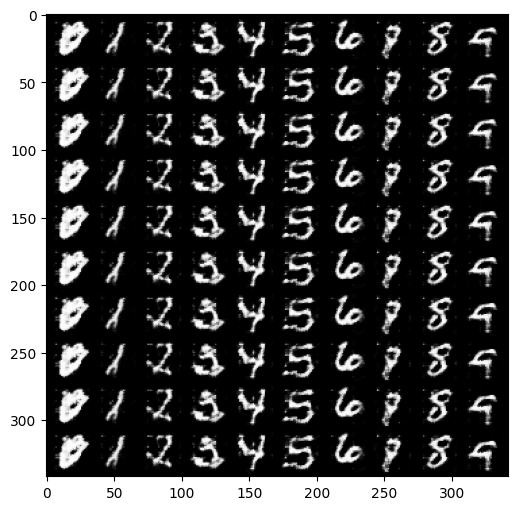

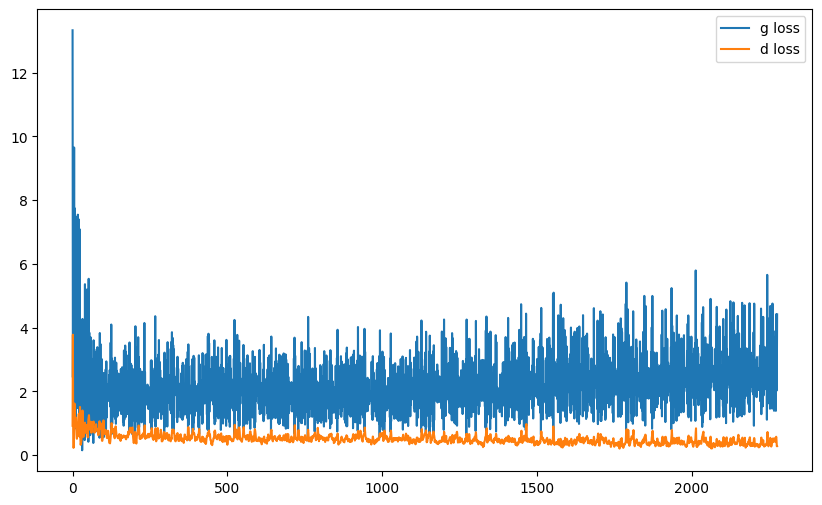

it: 2344; g_loss: 2.4341554641723633; d_loss: 0.3577123284339905; avg_real_score: 0.7024104595184326; avg_fake_score: 0.18734800815582275: : 469it [00:54,  8.60it/s]  


In [64]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)  # we generate the noise only once for testing


for epoch in range(nb_epochs):

    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch
        im = im.to(device)


        y = F.one_hot(labels).float().to(device)

        cur_batch_size = im.shape[0]


        ###################
        #                 #
        # YOUR CODE HERE  #
        #                 #
        ###################
        # 1. sample a z vector
        z = sample_z(cur_batch_size, nz)

        # 2. Generate a fake image
        fake_im = netG(z, y)


        # 3. Classify real image with D
        yhat_real = netD(im, y)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_im, y)
        
        real_loss = criterion(yhat_real, get_labels_one(cur_batch_size))
        fake_loss = criterion(yhat_fake, get_labels_zero(cur_batch_size))
        
        ###
        ### Discriminator
        ###

        d_loss = (real_loss + fake_loss) / 2
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) # we need to retain graph=True to be able to calculate the gradient in the g backprop
        d_opt.step()

        ###
        ### Generator
        ###


        g_loss = criterion(netD(fake_im, y), get_labels_one(cur_batch_size))
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()


        # Save Metrics

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")

        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)

            un_norm = renorm(fake_im) # for visualization

            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)

            plt.imshow(pil_grid)
            plt.show()


            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')

            plt.legend()
            plt.show()

        j += 1


## 4.2 Testing
Visualization of the impact of z on generation. All digits in the same column have the same noise vector z.

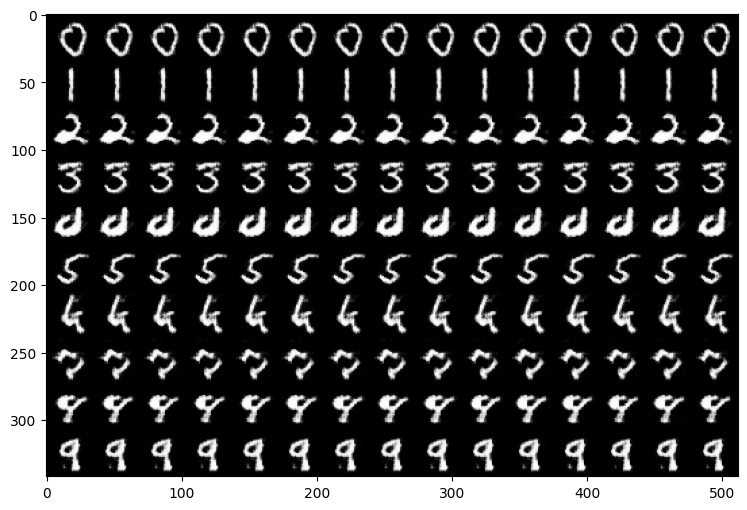

In [66]:
n_ex = 15
n_classes = 10

z = sample_z(n_ex, nz).repeat(n_classes, 1) #.expand(10, nz)

netG.eval()

labels = torch.arange(n_classes).unsqueeze(0).reshape(-1, 1).repeat(1, n_ex).flatten().to(device)

ys = F.one_hot(labels).float()
fake_ims = netG(z, ys)

un_norm= renorm(fake_ims) # for visualization
grid = torchvision.utils.make_grid(un_norm, nrow=n_ex)
pil_grid = to_pil(grid)

plt.imshow(pil_grid)
plt.show()
